# Import packages and data 

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import scipy.stats
import anndata
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.axes._axes import _log as matplotlib_axes_logger
from scipy import sparse
matplotlib_axes_logger.setLevel('ERROR')
import warnings
warnings.filterwarnings('ignore')

/Users/b8058304/.pyenv/versions/3.6.4/envs/py36/lib/python3.6/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
sc.settings.verbosity = 1  # verbosity: errors (0), warnings (1), info (2), hints (3)
# Set up the plot config for viewing the annotation clearly.
sc.settings.set_figure_params(dpi=120, dpi_save=1000)
sc.logging.print_versions()

scanpy==1.4.4 anndata==0.7.1 umap==0.3.10 numpy==1.18.1 scipy==1.4.1 pandas==1.0.2 scikit-learn==0.22.2.post1 statsmodels==0.11.1 python-igraph==0.8.0 louvain==0.6.1


# Load ABM raw dataset

In [4]:
adata = sc.read('/Users/b8058304/Documents/PhD_work/Coding/adult_bm/data/adult_bm_raw_dr_20200311.h5ad')

In [5]:
from scipy.sparse import csr_matrix
adata.X = sparse.csr_matrix(adata.X)

In [6]:
adata.raw = adata

In [7]:
cell_numbers = adata.obs.groupby(["cell.labels"]).apply(len)
cell_numbers

cell.labels
CD14 monocyte                   3094
CD16 monocyte                   1938
CD56 bright NK                  1228
CMP                              882
DC1                              135
DC2                              481
DC3                              550
EI macrophage                     77
ELP-B cell                        80
ELP-pDC                           63
GMP                              398
HSC                              862
MEMP                             505
MK                               577
MK progenitor                    280
MSC                              161
Pre B cell                       971
T reg                           6327
early MK                         136
early erythroid                 5441
immature B cell                 2728
interferon induced monocyte      576
late erythroid                  1150
mature CD8 T cell              15725
mature NK                       6074
memory B cell                   4106
memory CD4 T cell         

# Add broad annotation as metadata and accompanying colours

In [8]:
annot = pd.read_csv("/Users/b8058304/Documents/PhD_work/Coding/manuscript_figs/resources_for_pipelines/abm_broad_annots.csv")

In [9]:
refined_annot = annot["cell.labels "].tolist()
refined_annot

['CD14 monocyte',
 'CD16 monocyte',
 'CD56 bright NK',
 'CMP',
 'DC1',
 'DC2',
 'DC3',
 'EI macrophage',
 'ELP-B cell',
 'ELP-pDC',
 'GMP',
 'HSC',
 'MEMP',
 'MK',
 'MK progenitor',
 'MSC',
 'Pre B cell',
 'T reg',
 'early MK',
 'early erythroid',
 'immature B cell',
 'interferon induced monocyte',
 'late erythroid',
 'mature CD8 T cell',
 'mature NK',
 'memory B cell',
 'memory CD4 T cell',
 'mid erythroid',
 'monocyte precursor',
 'monocyte-DC',
 'myelocyte',
 'naive B cell',
 'naive CD4 T cell',
 'naive CD8 T cell',
 'neut myeloid',
 'neutrophil',
 'pDC',
 'plasma cell',
 'pre DC',
 'pre monocyte',
 'pro B progenitor',
 'promyelocyte',
 'transitional B cell',
 'transitional DC ',
 'transitional NK']

In [10]:
broad_annot = annot["broad_cell.labels"].tolist()
broad_annot

['monocyte',
 'monocyte',
 'T/NK',
 'HSC/MPP',
 'DC',
 'DC',
 'DC',
 'stroma',
 'HSC/MPP',
 'HSC/MPP',
 'HSC/MPP',
 'HSC/MPP',
 'HSC/MPP',
 'MK',
 'HSC/MPP',
 'stroma',
 'B lineage',
 'T/NK',
 'MK',
 'erythroid',
 'B lineage',
 'monocyte',
 'erythroid',
 'T/NK',
 'T/NK',
 'B lineage',
 'T/NK',
 'erythroid',
 'monocyte',
 'DC',
 'neutrophil',
 'B lineage',
 'T/NK',
 'T/NK',
 'HSC/MPP',
 'neutrophil',
 'DC',
 'B lineage',
 'DC',
 'monocyte',
 'B lineage',
 'neutrophil',
 'B lineage',
 'DC',
 'T/NK']

In [11]:
adata.obs["cell.labels_broad"] = adata.obs["cell.labels"].replace(refined_annot, broad_annot)

In [12]:
adata.obs["cell.labels_broad"] = adata.obs["cell.labels_broad"].astype('category')
adata.obs["cell.labels_broad"].cat.categories

Index(['B lineage', 'DC', 'HSC/MPP', 'MK', 'T/NK', 'erythroid', 'monocyte', 'neutrophil', 'stroma'], dtype='object')

In [13]:
adata.obs["cell.labels_broad"] = adata.obs["cell.labels_broad"].cat.reorder_categories(['HSC/MPP', 'erythroid', 'MK',
                     'B lineage', 'DC', 'neutrophil', 'monocyte', 'T/NK', 'stroma'])

In [14]:
adata.obs["cell.labels_broad"] = adata.obs["cell.labels_broad"].astype('category')
adata.obs["cell.labels_broad"].cat.categories

Index(['HSC/MPP', 'erythroid', 'MK', 'B lineage', 'DC', 'neutrophil', 'monocyte', 'T/NK', 'stroma'], dtype='object')

In [15]:
adata.obs["cell.labels_broad"].cat.categories[2]

'MK'

In [16]:
new_colors = np.empty(len(adata.obs["cell.labels_broad"].cat.categories), dtype=object) 

new_colors[[0]] = '#f9f06c' # HSC/MPP
new_colors[[1]] = '#f59771' # erythroid
new_colors[[2]] = '#8e88a8' # MK
new_colors[[3]] = '#d1db94' # B lineage
new_colors[[4]] = '#4d78bc' # DC
new_colors[[5]] = '#f3c3db' # neutrophil
new_colors[[6]] = '#86b3e0' # monocyte
new_colors[[7]] = '#d43d6a' # TNK
new_colors[[8]] = '#48b9b4' # stroma

adata.uns["cell.labels_broad_colors"] = new_colors

new_colors

array(['#f9f06c', '#f59771', '#8e88a8', '#d1db94', '#4d78bc', '#f3c3db',
       '#86b3e0', '#d43d6a', '#48b9b4'], dtype=object)

In [17]:
cell_numbers = adata.obs.groupby(["cell.labels"]).apply(len)
cell_numbers

cell.labels
CD14 monocyte                   3094
CD16 monocyte                   1938
CD56 bright NK                  1228
CMP                              882
DC1                              135
DC2                              481
DC3                              550
EI macrophage                     77
ELP-B cell                        80
ELP-pDC                           63
GMP                              398
HSC                              862
MEMP                             505
MK                               577
MK progenitor                    280
MSC                              161
Pre B cell                       971
T reg                           6327
early MK                         136
early erythroid                 5441
immature B cell                 2728
interferon induced monocyte      576
late erythroid                  1150
mature CD8 T cell              15725
mature NK                       6074
memory B cell                   4106
memory CD4 T cell         

In [18]:
cell_numbers = adata.obs.groupby(["cell.labels_broad"]).apply(len)
cell_numbers

cell.labels_broad
HSC/MPP        4510
erythroid      8783
MK              713
B lineage     32685
DC             3352
neutrophil    11354
monocyte      13056
T/NK          67335
stroma          238
dtype: int64

# Pre-process the total dataset

In [19]:
# normalise count data 
sc.pp.normalize_total(adata)

In [20]:
# log the count data 
sc.pp.log1p(adata)

In [21]:
# find variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5) 

In [22]:
# scale the data 
sc.pp.scale(adata, max_value=10)
# scale the negative values in adata.X (which have been normalised, logged and scaled) to zero 
adata.X = np.where(adata.X < 0, 0, adata.X)

In [23]:
# run pca
sc.tl.pca(adata, n_comps=50)

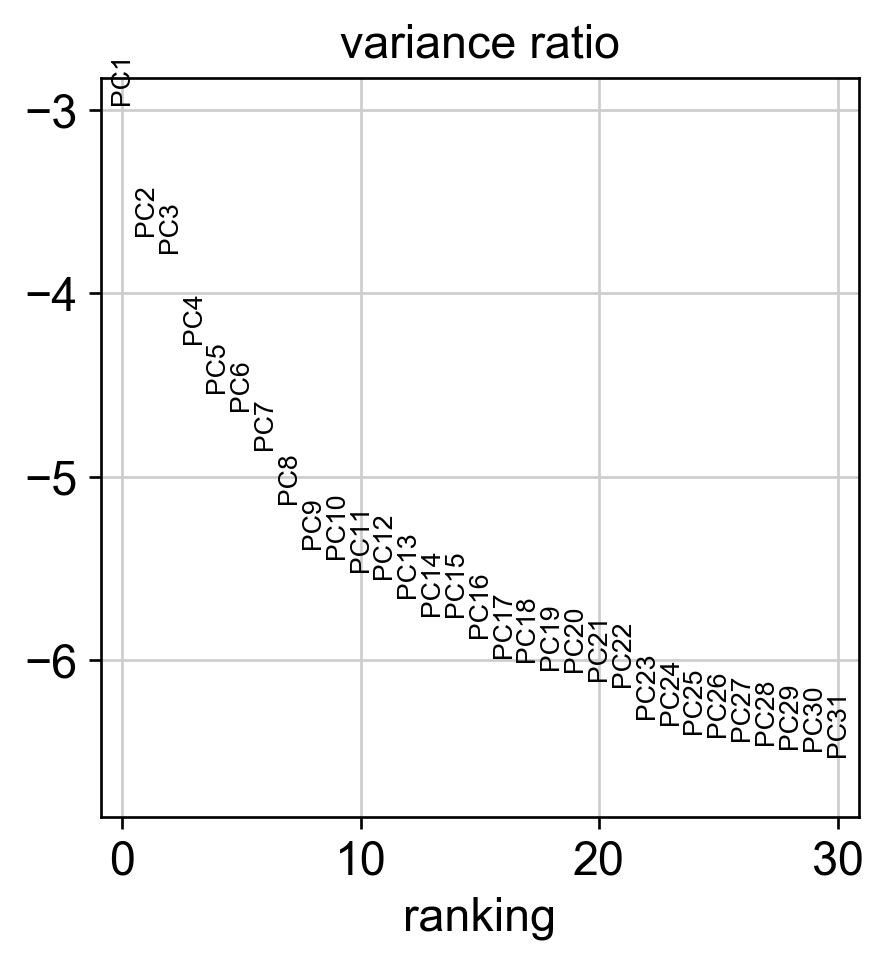

In [24]:
# have a look at pc's in order to choose number of pcs that will be used downstream 
sc.pl.pca_variance_ratio(adata, log=True)

In [25]:
# run snn neighbourhood graph
sc.pp.neighbors(adata, n_neighbors=40, n_pcs=30) 

In [26]:
# run umap
sc.tl.umap(adata) 

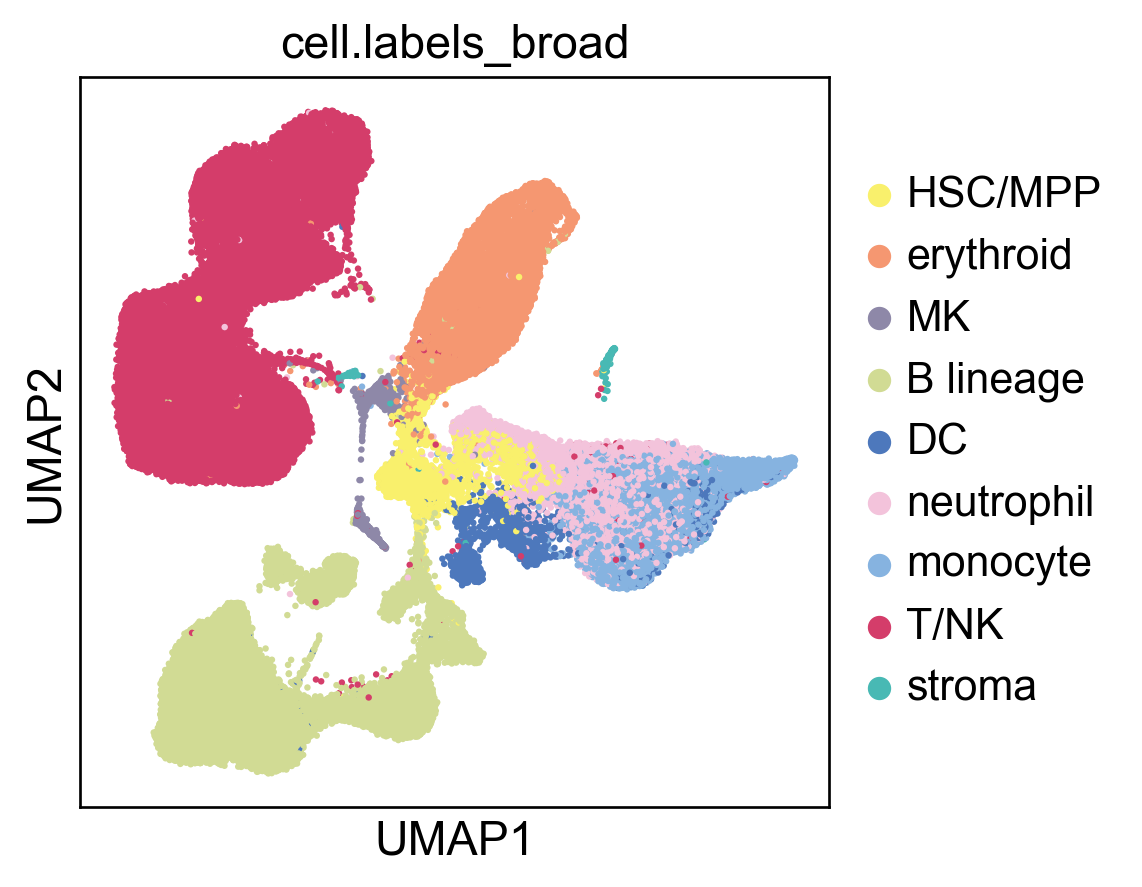

In [27]:
sc.pl.umap(adata, color=['cell.labels_broad'], size=15) 

In [28]:
## UMAP
sc.pl.umap(adata, color='cell.labels', save='_abm_19pcw_pre-harmony_20200427_labels_legoff.pdf', show=False, size=15) 
sc.pl.umap(adata, color='cell.labels', save='_abm_19pcw_pre-harmony_20200427_labels_legon.pdf', show=False, size=15, legend_loc="on data", legend_fontsize=6)

sc.pl.umap(adata, color='cell.labels_broad', save='_abm_19pcw_pre-harmony_20200427_labels_broad_legoff.pdf', show=False, size=15) 
sc.pl.umap(adata, color='cell.labels_broad', save='_abm_19pcw_pre-harmony_20200427_labels_broad_legon.pdf', show=False, size=15, legend_loc="on data", legend_fontsize=6)

sc.pl.umap(adata, color='sample', save='_abm_pre-harmony_20200427_sample_legoff.pdf', show=False, size=15) 
sc.pl.umap(adata, color='sample', save='_abm_pre-harmony_20200427_sample_legon.pdf', show=False, size=15, legend_loc="on data", legend_fontsize=6)

# Run harmony batch correction

In [29]:
#harmony prep - save pca and batch (sample) metadata columns 
pca = adata.obsm['X_pca']
batch = adata.obs['sample']

In [30]:
# load up harmony in rpy2
%load_ext rpy2.ipython

In [31]:
%%R -i pca -i batch -o hem

library(harmony)
library(magrittr)

hem = HarmonyMatrix(pca, batch, theta=3, verbose=TRUE, do_pca=FALSE)
hem = data.frame(hem)

R[write to console]: Loading required package: Rcpp

R[write to console]: Harmony 1/10

R[write to console]: 0%   10   20   30   40   50   60   70   80   90   100%

R[write to console]: [----|----|----|----|----|----|----|----|----|----|

R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[

R[write to console]: Harmony 7/10

R[write to console]: 0%   10   20   30   40   50   60   70   80   90   100%

R[write to console]: [----|----|----|----|----|----|----|----|----|----|

R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write t

In [32]:
# save old pca values or orig.pca and save batch corrected pca results in anndata object as x_pca
adata.obsm['X_orig_pca'] = adata.obsm['X_pca']
adata.obsm['X_pca'] = hem.values

# Add UMAP 

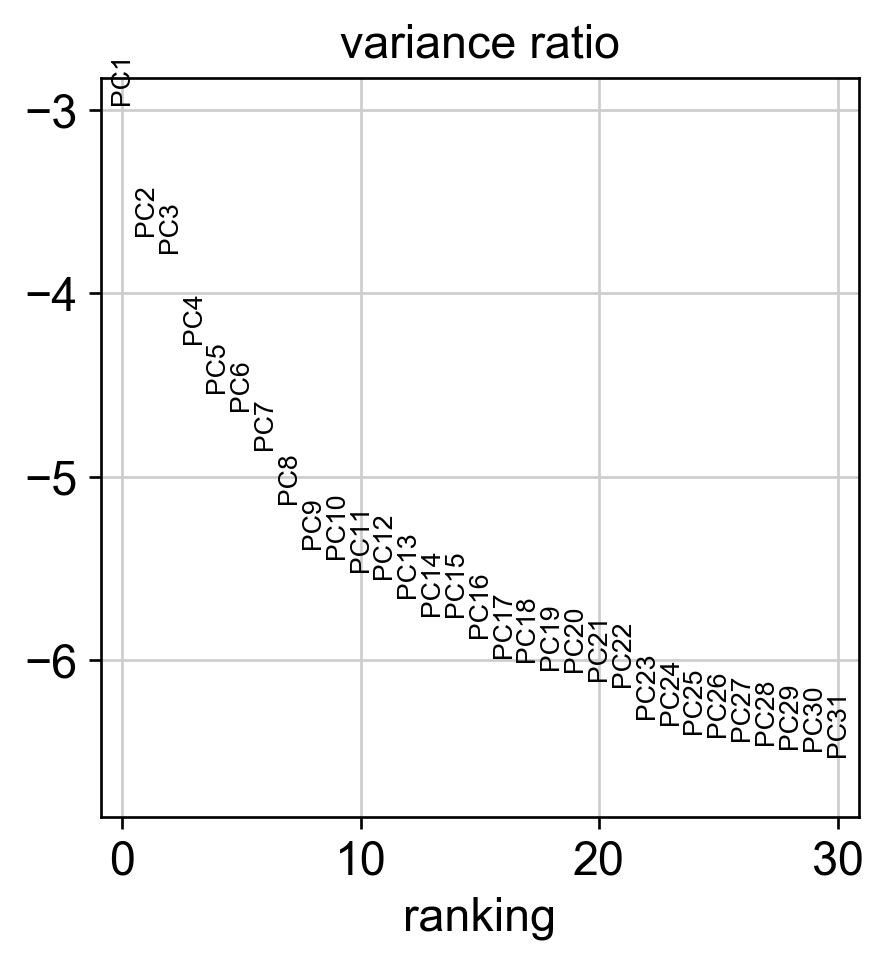

In [33]:
# have a look at pc's in order to choose number of pcs that will be used downstream 
sc.pl.pca_variance_ratio(adata, log=True)

In [34]:
# run snn neighbourhood graph
sc.pp.neighbors(adata, n_neighbors=40, n_pcs=20) 

In [35]:
# run umap
sc.tl.umap(adata) 

# Plot UMAP

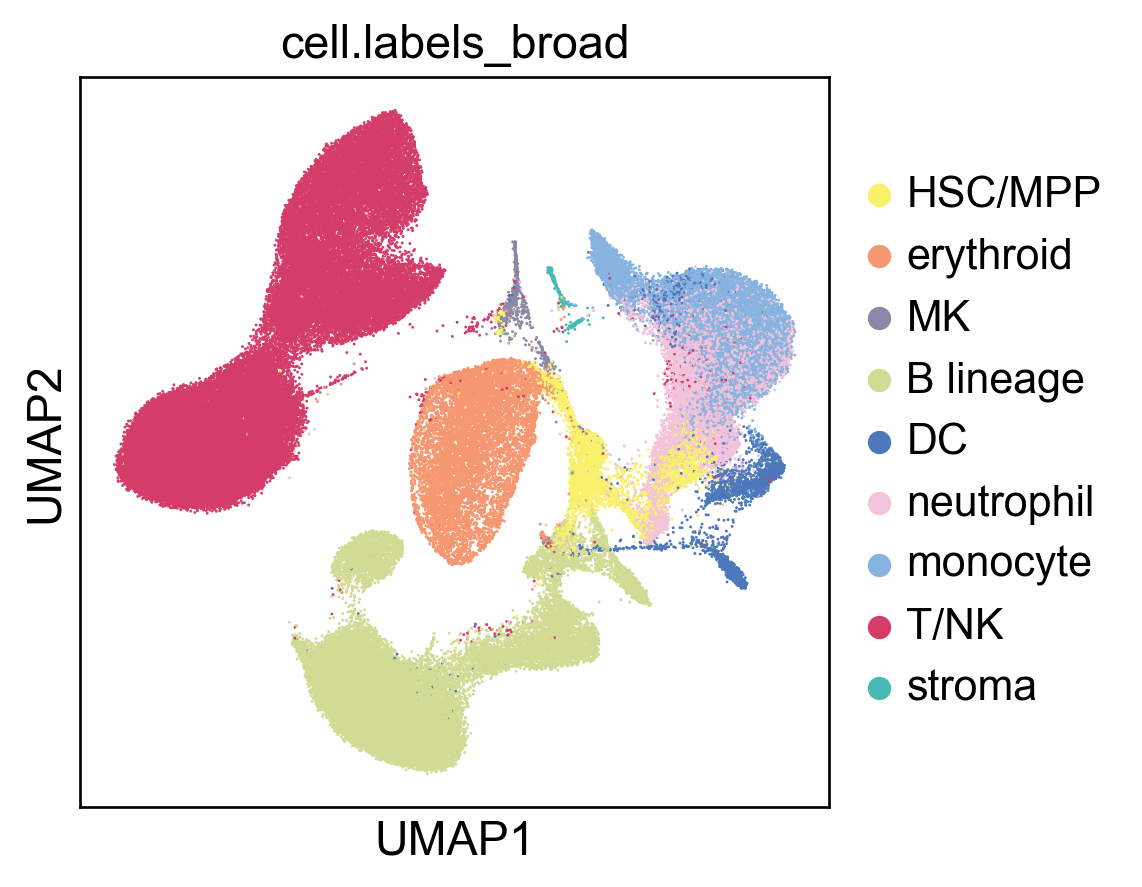

In [36]:
sc.pl.umap(adata, color=['cell.labels_broad'], size=3)

In [37]:
## UMAP
sc.pl.umap(adata, color='cell.labels', save='_abm_19pcw_post-harmony_20200427_labels_legoff.pdf', show=False, size=3) 
sc.pl.umap(adata, color='cell.labels', save='_abm_19pcw_post-harmony_20200427_labels_legon.pdf', show=False, size=3, legend_loc="on data", legend_fontsize=6)

sc.pl.umap(adata, color='cell.labels_broad', save='_abm_19pcw_post-harmony_20200427_labels_broad_legoff.pdf', show=False, size=3) 
sc.pl.umap(adata, color='cell.labels_broad', save='_abm_19pcw_post-harmony_20200427_labels_broad_legon.pdf', show=False, size=3, legend_loc="on data", legend_fontsize=6)

sc.pl.umap(adata, color='sample', save='_abm_post-harmony_20200427_sample_legoff.pdf', show=False, size=3) 
sc.pl.umap(adata, color='sample', save='_abm_post-harmony_20200427_sample_legon.pdf', show=False, size=3, legend_loc="on data", legend_fontsize=6)

# Save the data

In [38]:
from scipy.sparse import csr_matrix
adata.X = sparse.csr_matrix(adata.X)

In [39]:
adata.X

<142026x33694 sparse matrix of type '<class 'numpy.float32'>'
	with 127477575 stored elements in Compressed Sparse Row format>

In [40]:
adata.raw.X

<142026x33694 sparse matrix of type '<class 'numpy.float32'>'
	with 138303174 stored elements in Compressed Sparse Row format>

In [41]:
adata.write("/Users/b8058304/Documents/PhD_work/Coding/manuscript_figs/data/figs1d_abm_scaled_gex_updated_dr_20200427.h5ad")

In [42]:
adata.shape

(142026, 33694)